In [1]:
import os
import src

In [2]:
sheet = src.Sheet('samples/paraclis.pdf')

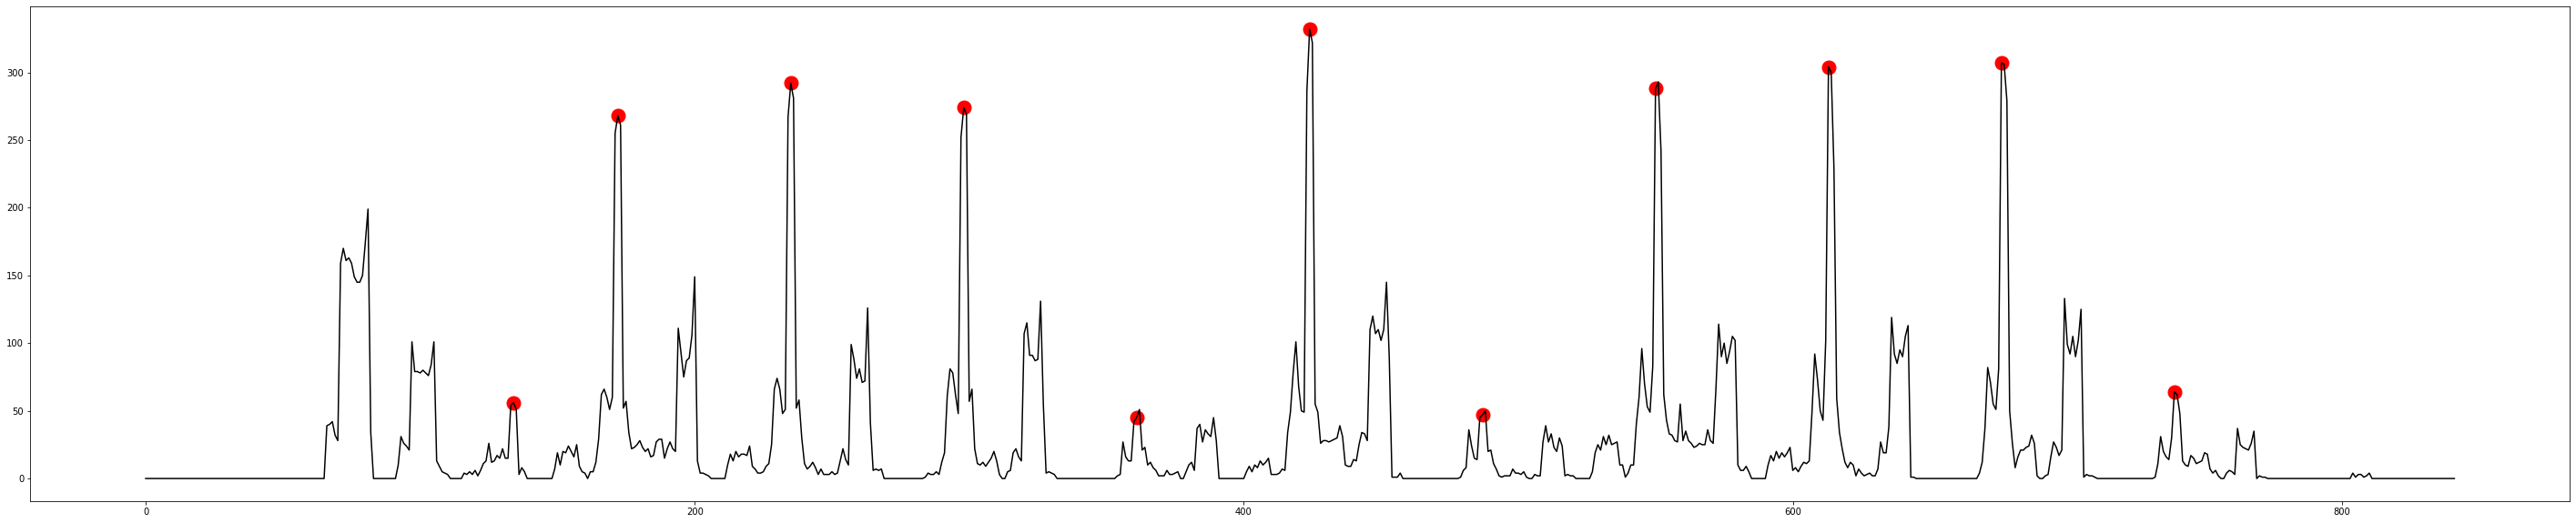

In [3]:
sheet[4].plot_raw_horizontal_projection()

['y = 134', 'y = 172', 'y = 235', 'y = 298', 'y = 361', 'y = 424', 'y = 487', 'y = 550', 'y = 613', 'y = 676', 'y = 739']
b1=y = 134
b2=y = 172
fst_pos=162 mid=153.0
! max=[150 152 154 157]
! rhp_max=[19. 20. 24. 25.]
rightmost_max_index=157
rm_min_index=148
b1=y = 172
b2=y = 235
fst_pos=212 mid=203.5
! max=[180 183 187 191 194 200]
! rhp_max=[ 28.  22.  29.  27. 111. 149.]
rightmost_max_index=200
rm_min_index=189
b1=y = 235
b2=y = 298
fst_pos=284 mid=266.5
! max=[243 246 250 254 257 260 263 266 268]
! rhp_max=[ 12.   7.   5.  22.  99.  81. 126.   7.   7.]
rightmost_max_index=268
rm_min_index=251
b1=y = 298
b2=y = 361
fst_pos=354 mid=329.5
! max=[305 309 317 321 326 329]
! rhp_max=[ 12.  20.  22. 115. 131.   5.]
rightmost_max_index=329
rm_min_index=313
b1=y = 361
b2=y = 424
fst_pos=401 mid=392.5
! max=[366 372 376 381 384 386 389]
! rhp_max=[12.  6.  5. 12. 40. 36. 45.]
rightmost_max_index=389
rm_min_index=378
b1=y = 424
b2=y = 487
fst_pos=479 mid=455.5
! max=[429 435 440 443 447 449 4

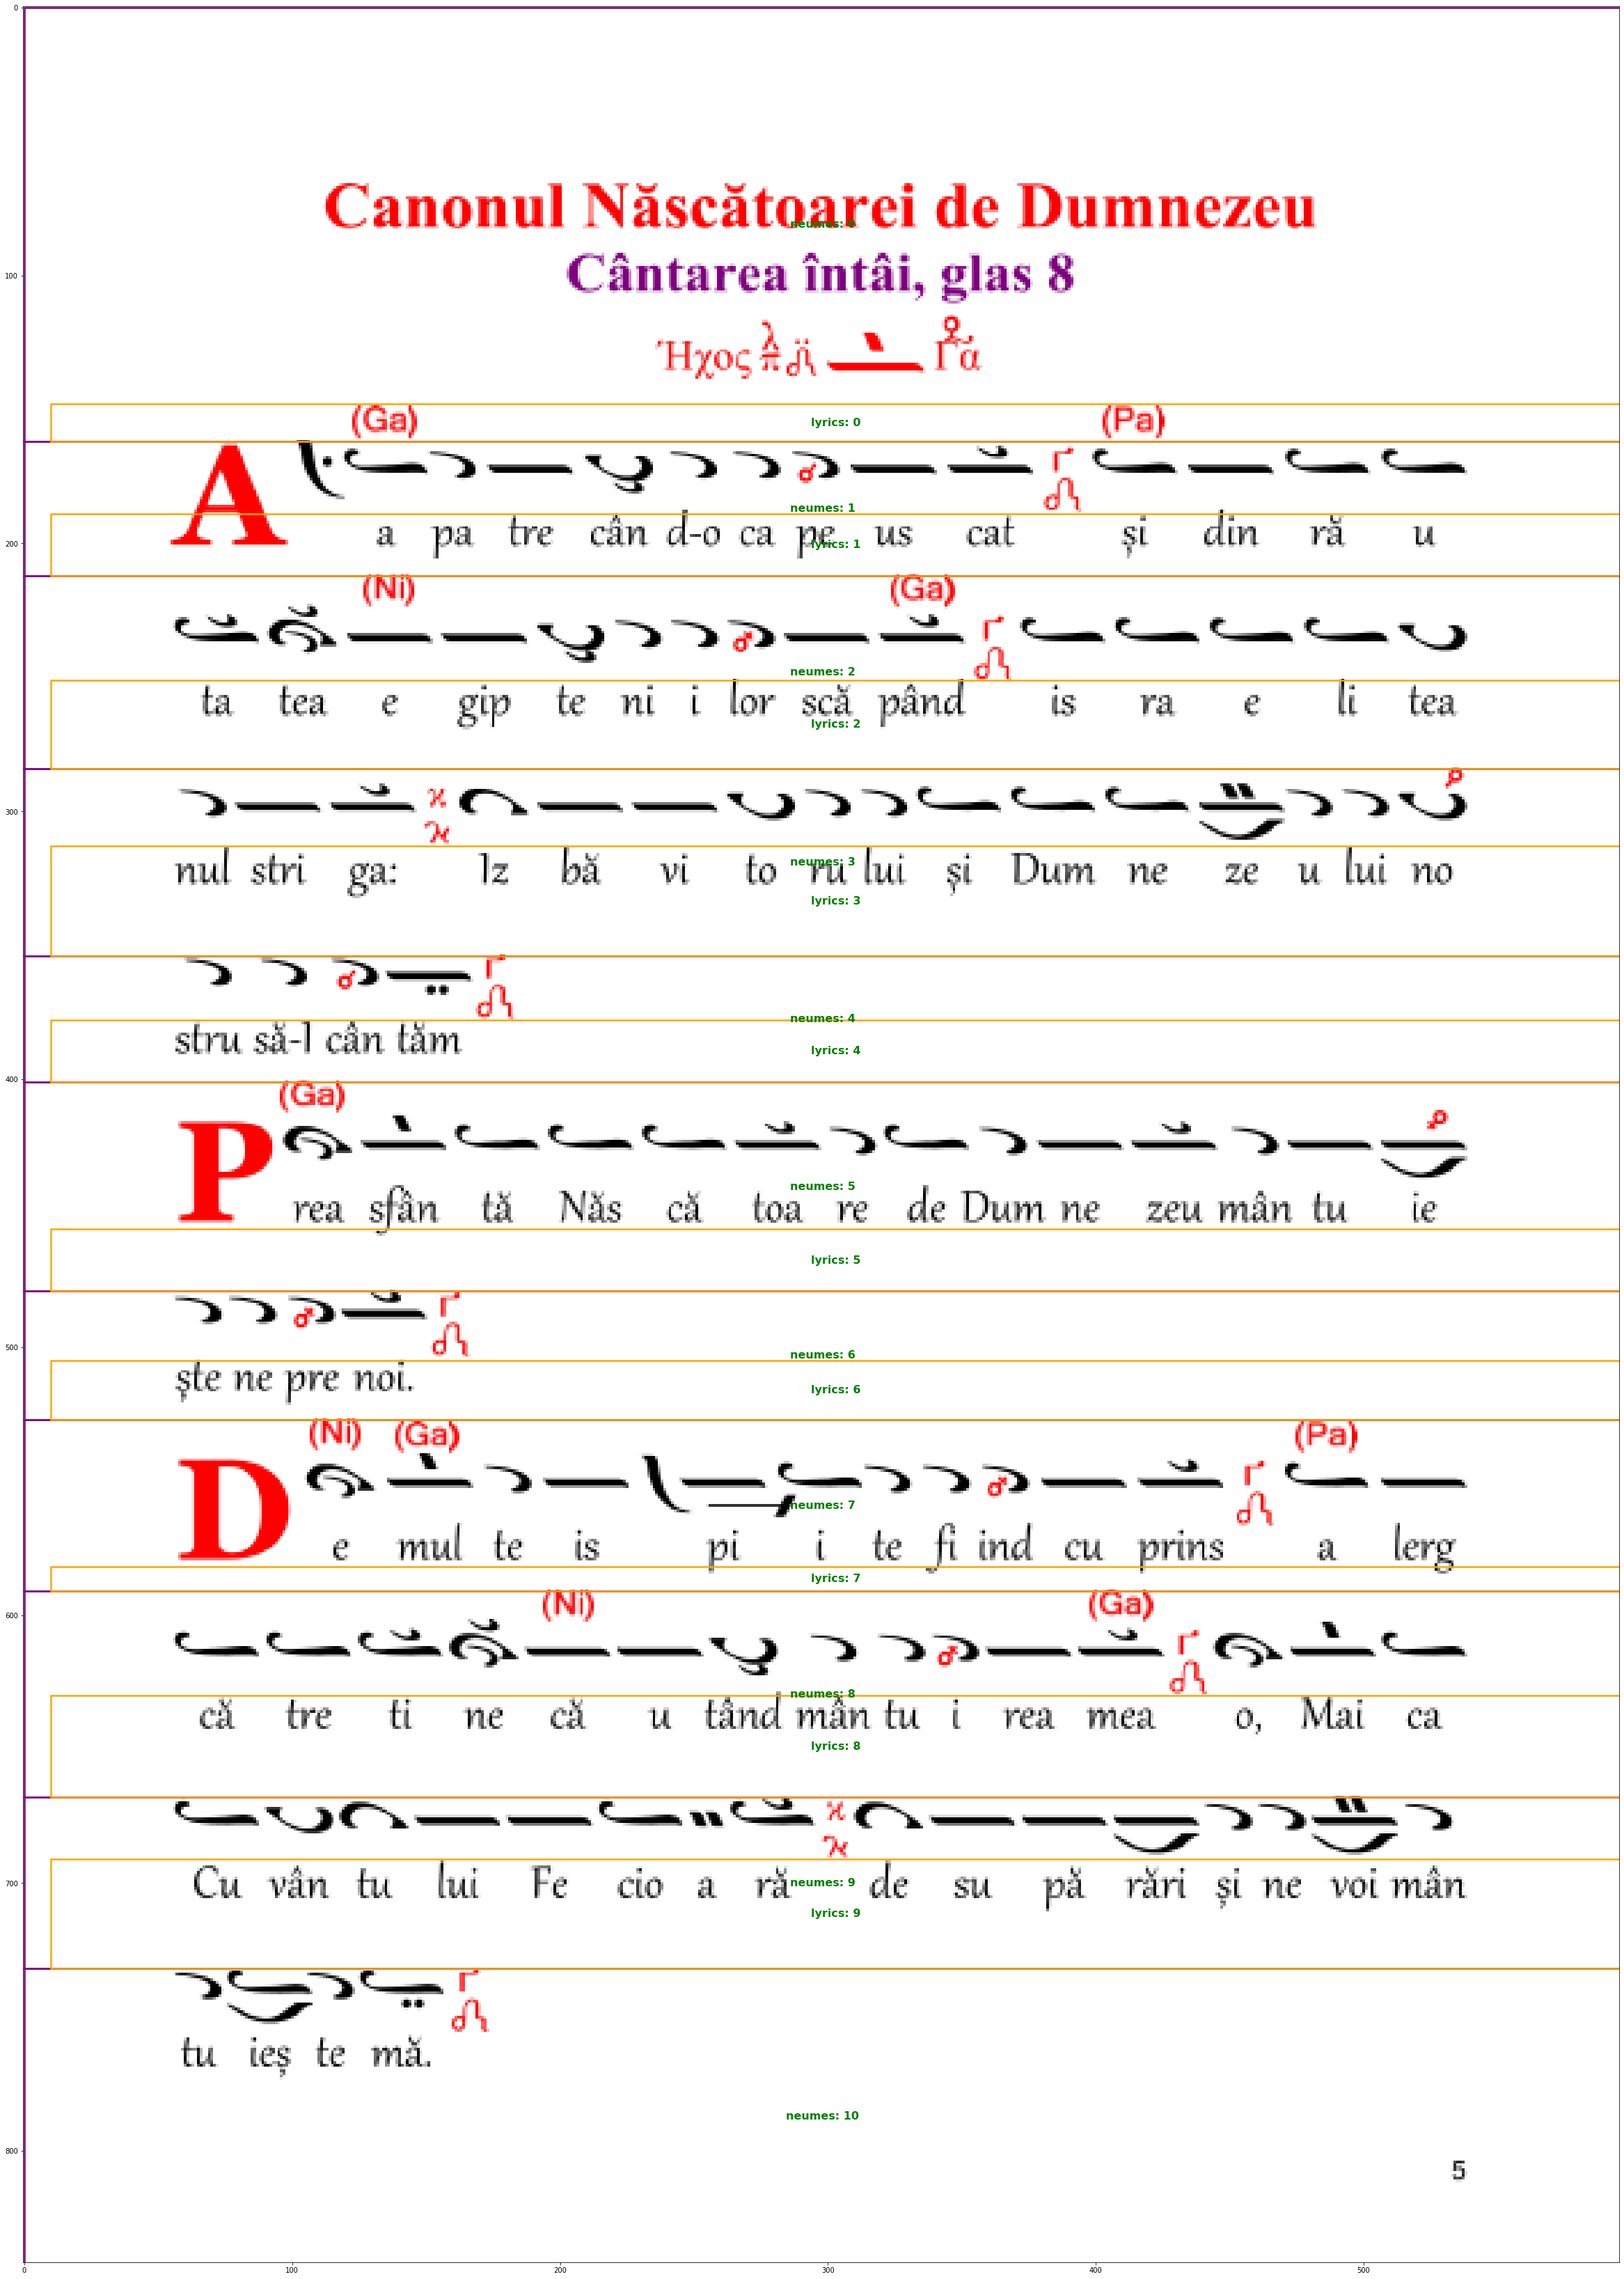

In [4]:
sheet[4].plot_full_baselines()

32


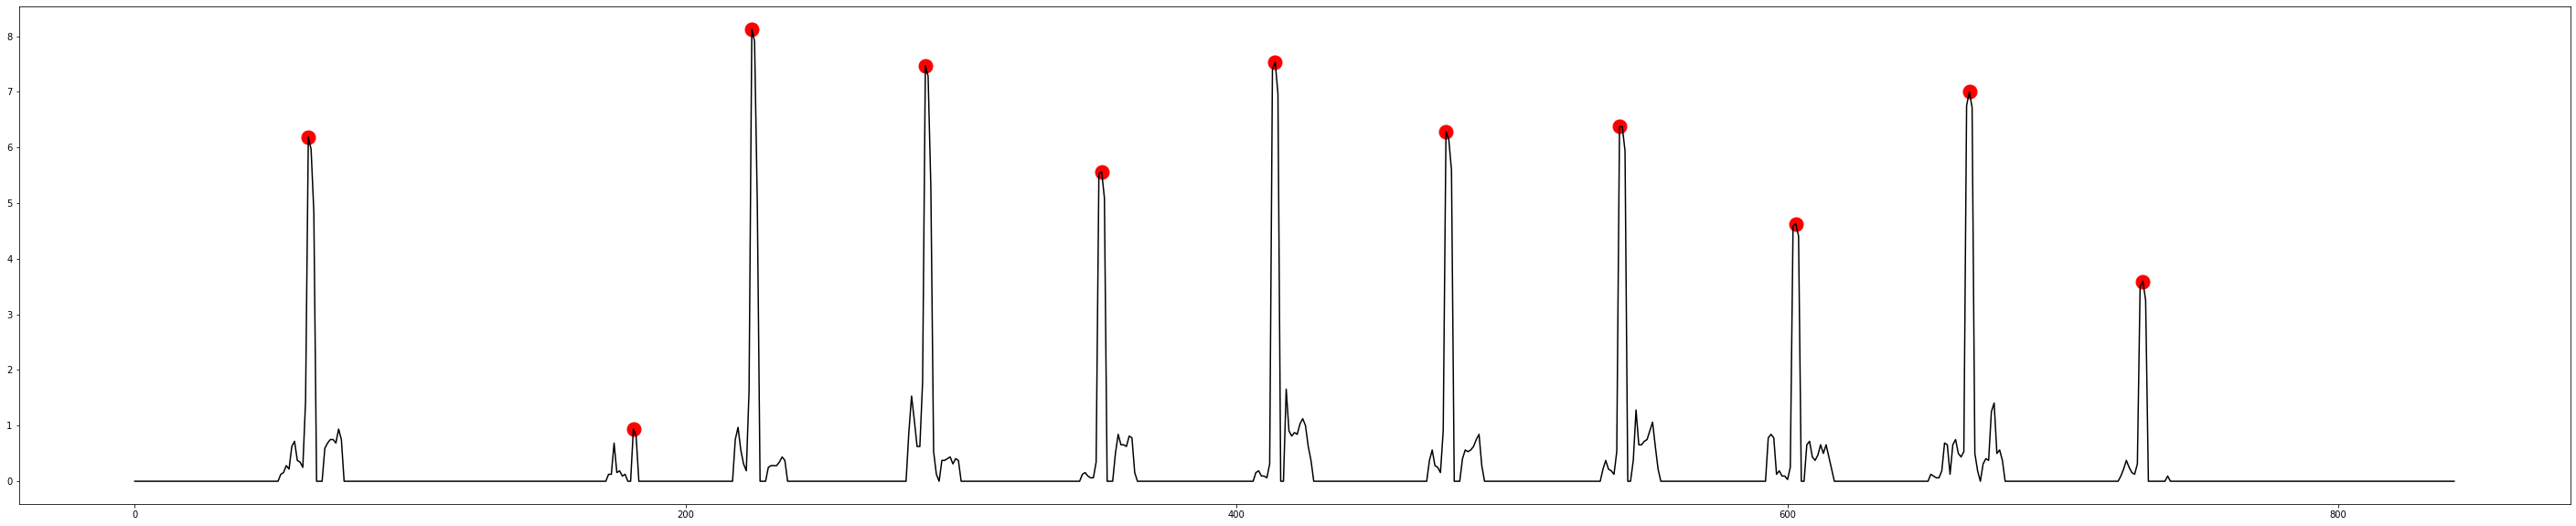

In [5]:
print(sheet.oligon_width)
sheet[24].plot_horizontal_projection()

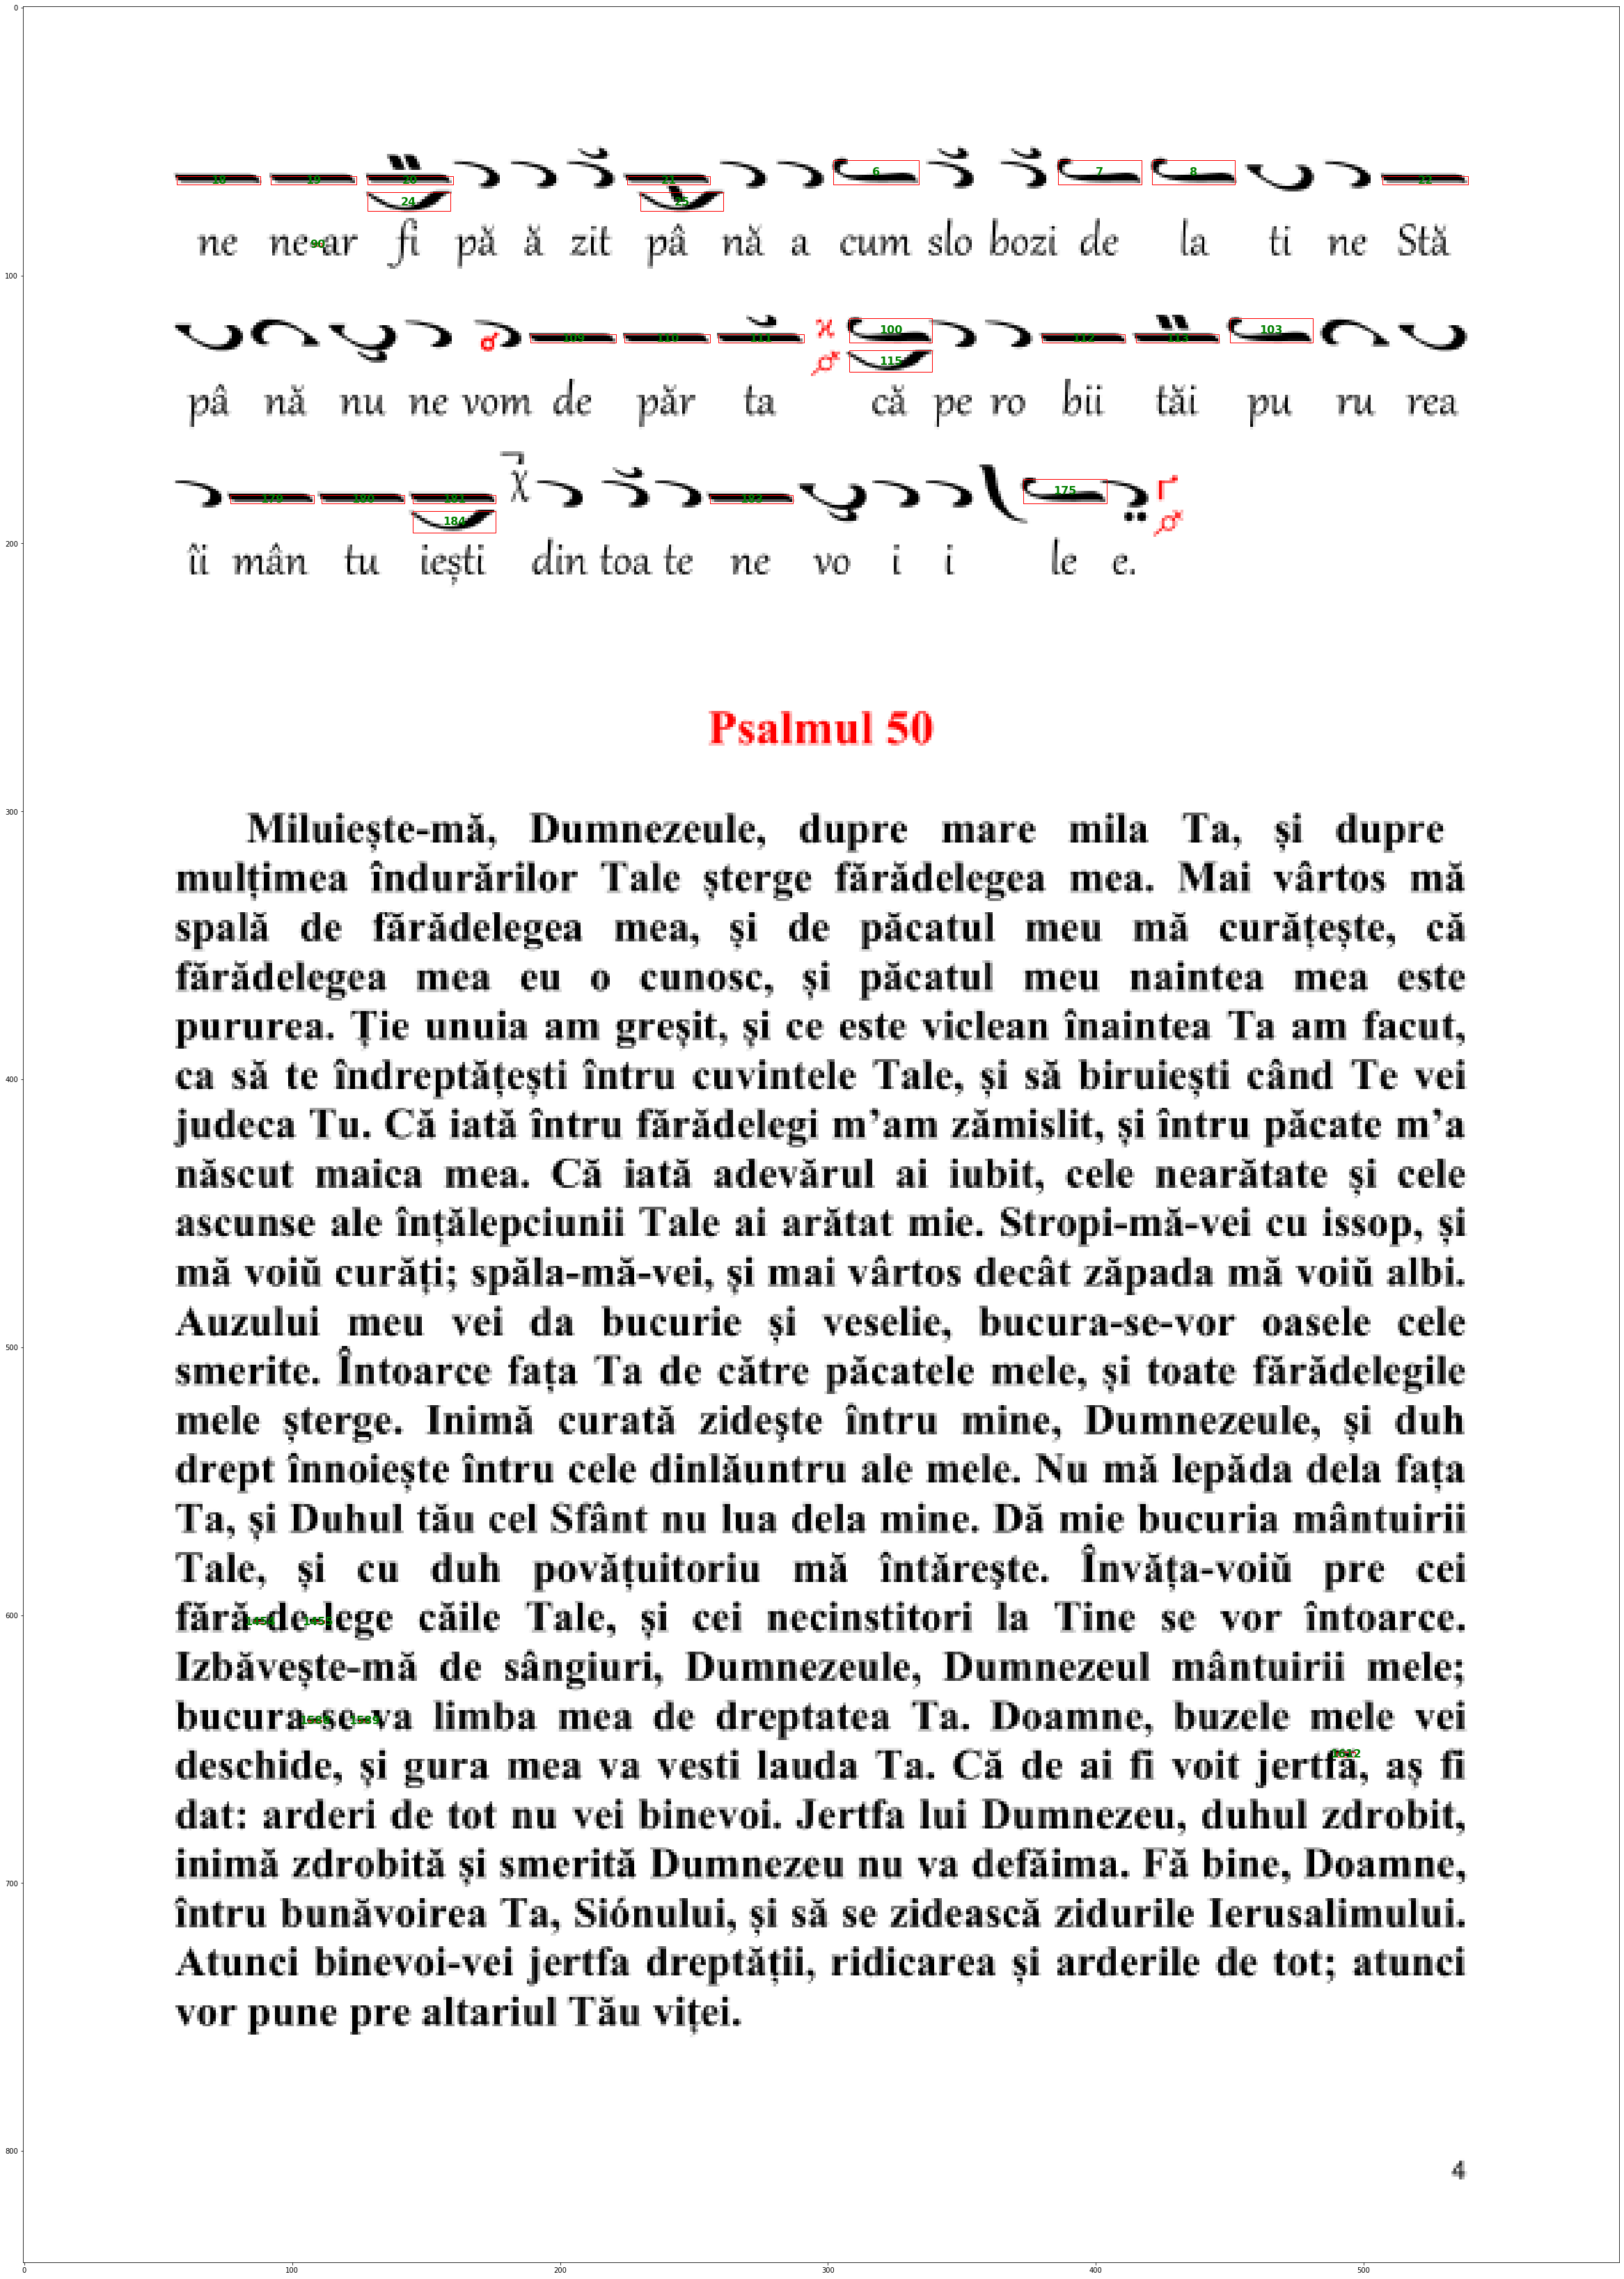

In [6]:
sheet[3].plot_ccs()